In this notebook, we do time varying simulations for the ORGaNICs circuit.

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import numpy as np
from joblib import Parallel, delayed, parallel_backend
import argparse
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings
import shutil
import json

In [2]:
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}

b0 = 1.0 * torch.ones(N)
b1 = 1.0 * torch.ones(N)

sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [3]:
mu = 0.0
delta = 0.1

Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)

In [4]:
# define the time vector
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max= max(torch.max(tauA), torch.max(tauY))
time = tau_max * 200
dt = 0.05 * tau_min
points = int(time / dt)
t = torch.linspace(0, time, points)

In [6]:
def z_delocalized_increasing_input_norm(t, *, N=10, time_scale=1.0):
    """
    Returns a delocalized (normalized ones) vector scaled by an increasing factor.
    
    Parameters:
      t         : Time (float).
      N         : Dimension of the vector (int).
      time_scale: Time scaling factor determining the rate of increase (float).
    
    Returns:
      A tensor of shape (N,) whose norm increases with t.
    """
    # Create a delocalized vector (all ones normalized)
    vec = torch.ones(N) / torch.norm(torch.ones(N))
    # Define an increasing scalar (e.g., starting at 0 and increasing linearly)
    scale = t / time_scale
    return scale * vec

def z_delocalized_random_input_norm(t, *, N=10, uniform_low=0.0, uniform_high=1.0):
    """
    Returns a delocalized (normalized ones) vector scaled by a random factor 
    sampled uniformly between `uniform_low` and `uniform_high`.
    
    Parameters:
      t           : Time (float). (Not used in the computation, but kept for API consistency.)
      N           : Dimension of the vector (int).
      uniform_low : Lower bound of the uniform distribution (float).
      uniform_high: Upper bound of the uniform distribution (float).
    
    Returns:
      A tensor of shape (N,) whose norm is randomly sampled at each time step.
    """
    # Create a delocalized vector (all ones normalized)
    vec = torch.ones(N) / torch.norm(torch.ones(N))
    # Randomly sample the scale from a uniform distribution
    scale = torch.empty(1).uniform_(uniform_low, uniform_high).item()
    return scale * vec

def z_localized_increasing_input_norm(t, *, N=10, time_scale=1.0, index=0):
    """
    Returns a localized (one-hot) vector scaled by an increasing factor.
    
    Parameters:
      t         : Time (float).
      N         : Dimension of the vector (int).
      time_scale: Time scaling factor for the increasing function (float).
      index     : The index to set to 1 for the one-hot vector.
    
    Returns:
      A tensor of shape (N,) whose norm increases with t.
    """
    # Create a localized one-hot vector
    vec = torch.zeros(N)
    vec[index] = 1.0
    scale = t / time_scale
    return scale * vec

def z_localized_random_input_norm(t, *, N=10, uniform_low=0.0, uniform_high=1.0, index=0):
    """
    Returns a localized (one-hot) vector scaled by a random factor 
    sampled uniformly between `uniform_low` and `uniform_high`.
    
    Parameters:
      t           : Time (float). (Not used in the computation, but kept for API consistency.)
      N           : Dimension of the vector (int).
      uniform_low : Lower bound of the uniform distribution (float).
      uniform_high: Upper bound of the uniform distribution (float).
      index       : The index to set to 1 for the one-hot vector.
    
    Returns:
      A tensor of shape (N,) whose norm is randomly sampled at each time step.
    """
    # Create a localized one-hot vector
    vec = torch.zeros(N)
    # sample the index from 0 to N-1 uniformly
    index = torch.randint(0, N, (1,)).item()
    vec[index] = 1.0
    # Randomly sample the scale from a uniform distribution
    scale = torch.empty(1).uniform_(uniform_low, uniform_high).item()
    return scale * vec

def z_delocalized_to_localized(t, *, N=10, transition_time=1.0, index=0, input_norm=1.0):
    """
    Returns a vector that transitions from delocalized to localized as time increases.
    The overall vector is re-normalized to have fixed norm.
    
    Parameters:
      t              : Time (float).
      N              : Dimension of the vector (int).
      transition_time: Time scale over which the transition occurs (float).
      index          : The index to set to 1 for the localized (one-hot) part.
    
    Returns:
      A normalized tensor of shape (N,) that starts delocalized and becomes localized.
    """
    # f goes from 0 (at t=0, fully delocalized) to 1 (at t >= transition_time, fully localized)
    f = min(1.0, t / transition_time)
    
    # Delocalized component: normalized ones
    v_deloc = torch.ones(N) / torch.norm(torch.ones(N))
    
    # Localized component: one-hot vector
    v_loc = torch.zeros(N)
    v_loc[index] = 1.0
    
    # Blend the two vectors and then re-normalize (fixed norm)
    v = (1 - f) * v_deloc + f * v_loc
    v = v / torch.norm(v) * input_norm
    return v

def z_delocalized_norm_steps(t, *, N=10, norm_list=None, step_duration=0.002):
    """
    Returns a delocalized (all ones normalized) vector with a piecewise constant norm.
    The norm is chosen from `norm_list` based on the current time t and the given step_duration.
    
    Parameters:
      t            : Time (float).
      N            : Dimension of the vector.
      norm_list    : List (or 1D tensor) of norm values. The total simulation time will be len(norm_list) * step_duration.
      step_duration: Duration for which each norm value holds (e.g., set to tauA[0] or another relevant time constant).
    
    Returns:
      A tensor of shape (N,) equal to norm_list[current_step] times a delocalized (normalized ones) vector.
    """
    if norm_list is None:
        raise ValueError("norm_list must be provided.")
    # Determine which step we are in
    index = int(t // step_duration)
    if index >= len(norm_list):
        index = len(norm_list) - 1
    # Create a delocalized (uniform) vector
    vec = torch.ones(N) / torch.norm(torch.ones(N))
    return norm_list[index] * vec

In [7]:
def z_vals(z_func, t_values, **kwargs):
    """
    Evaluates the provided z function over a series of time values.
    
    Parameters:
      z_func : A function that accepts time t as its first argument.
      t_values: An iterable of time values.
      kwargs : Additional keyword arguments to pass to z_func.
    
    Returns:
      A tensor of shape (len(t_values), N) stacking the results of z_func.
    """
    results = [z_func(t, **kwargs) for t in t_values]
    return torch.stack(results)

In [52]:
z_func = z_delocalized_increasing_input_norm

model = organics.ORGaNICs2Dgeneral_time_varying_input(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z_func,
        N=N,
    )

In [53]:
sim_obj = sim_solution(model)
sim = sim_obj.simulate(t, y0=model.initial_sim)

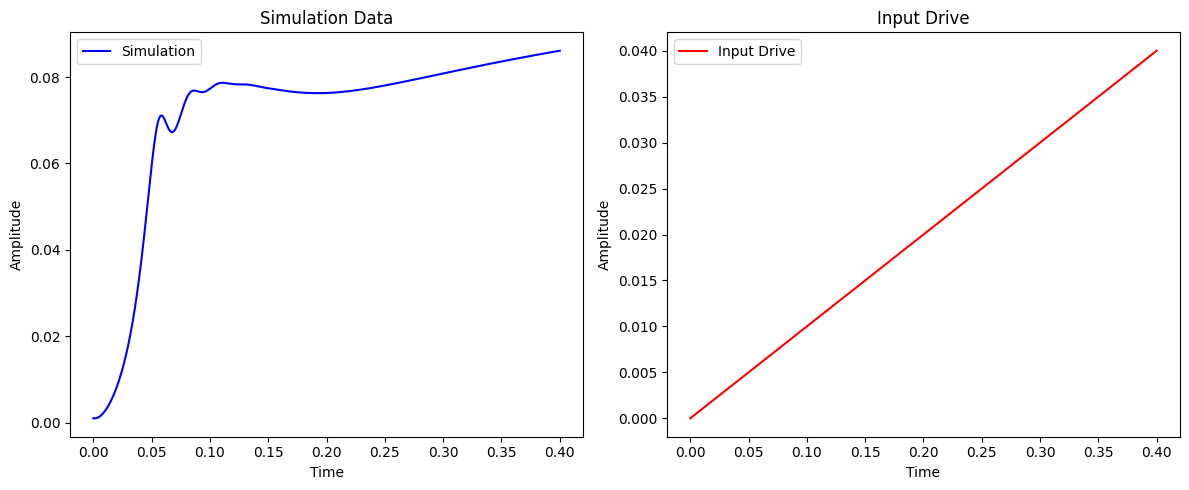

In [58]:
# Assume idx, t, sim, z_func, model.kwargs are already defined
idx = 10

# Compute the input drive using your z_vals function
input_drive = z_vals(z_func, t, **model.kwargs)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the simulation data on the left subplot
axes[0].plot(t, sim[:, idx].detach().numpy(), label='Simulation', color='blue')
axes[0].set_title('Simulation Data')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
# axes[0].grid(True)

# Plot the input drive data on the right subplot
axes[1].plot(t, input_drive[:, idx].detach().numpy(), label='Input Drive', color='red')
axes[1].set_title('Input Drive')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
# axes[1].grid(True)

# Adjust layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()

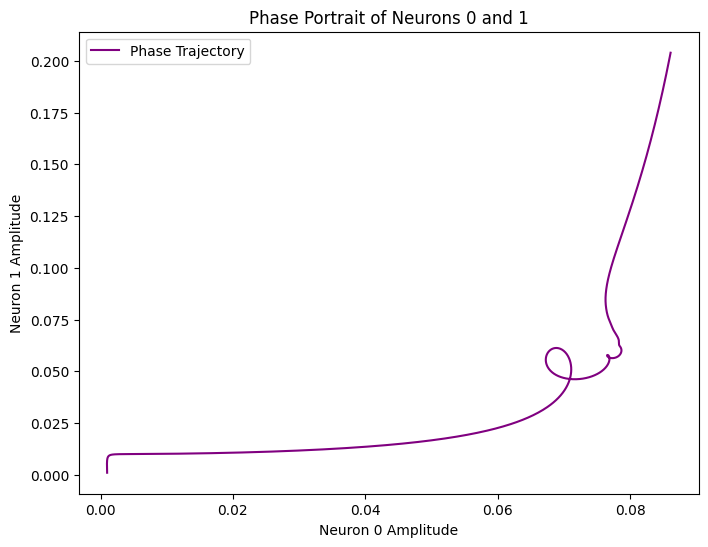

In [63]:
# Extract the simulation data for neurons 0 and 1
sim_neuron0 = sim[:, idx].detach().numpy()
sim_neuron1 = sim[:, idx + 101].detach().numpy()

# Create the phase portrait plot
plt.figure(figsize=(8, 6))
plt.plot(sim_neuron0, sim_neuron1, label='Phase Trajectory', color='purple')
plt.xlabel('Neuron 0 Amplitude')
plt.ylabel('Neuron 1 Amplitude')
plt.title('Phase Portrait of Neurons 0 and 1')
plt.legend()
# plt.grid(True)
plt.show()